In [8]:
import tensorflow.compat.v2 as tf
import tensorflow_hub as hub
import numpy as np
from PIL import Image

In [63]:
class CustomModel(tf.keras.Model):
    def __init__(self, hub_url = None):
        super(CustomModel, self).__init__()
        hub_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_035_128/feature_vector/4"
        self.hub_layer = hub.KerasLayer(hub_url, input_shape=(128, 128, 3), trainable=False)  # Or True, depending on your needs
        self.dense1 = tf.keras.layers.Dense(30, activation='relu')
        self.dense2 = tf.keras.layers.Dense(4, activation='linear')

    def call(self, inputs):
        x = self.hub_layer(inputs)
        x = self.dense1(x)
        return self.dense2(x)

In [79]:
model = CustomModel()
#model.build([None, 128, 128, 3])
model.compile(optimizer='adam', loss='mean_squared_error')

In [23]:
def prepare_image(image_path, target_size=(513, 513)):
    """
    Load an image file and prepare it for model prediction.
    """
    # Load the image
    image = Image.open(image_path)
    
    # Resize the image
    image = image.resize(target_size)
    
    # Convert the image to a numpy array and normalize it
    image = np.array(image) / 255.0
    
    # Ensure it's in the right shape (batch size, height, width, channels)
    #image = np.expand_dims(image, axis=0)
    
    return image

In [29]:
image_path = '/home/julius/Hack/nutrition5k_dataset_nosides/imagery/realsense_overhead/dish_1563216717/rgb.png'
prepared_image = prepare_image(image_path, target_size=(128, 128))
prepared_image.shape


(1, 128, 128, 3)

In [34]:
import pandas as pd

df = pd.read_pickle('df.pkl')


In [47]:
y = df.iloc[:,2:-1]

In [48]:
y.shape

(3261, 4)

In [78]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
y = scaler.fit_transform(y)

In [70]:
X = [e[0][None] for e in df['image']]

In [71]:
X[0].shape

(1, 128, 128, 3)

In [72]:
X = np.concatenate(X, axis=0)

In [73]:
X.shape

(3261, 128, 128, 3)

In [86]:
history = model.fit(X[:20],y[:20], epochs=100, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/100


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0087 - val_loss: 0.1999
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0247 - val_loss: 0.1994
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0232 - val_loss: 0.1996
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0117 - val_loss: 0.2003
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0122 - val_loss: 0.2009
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0085 - val_loss: 0.2012
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0087 - val_loss: 0.2011
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0084 - val_loss: 0.2008
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0087 - val_loss: 0.2010
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0113 - val_loss: 0.2015
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0085 - val_loss: 0.2021
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0127 - val_loss: 0.2023
E

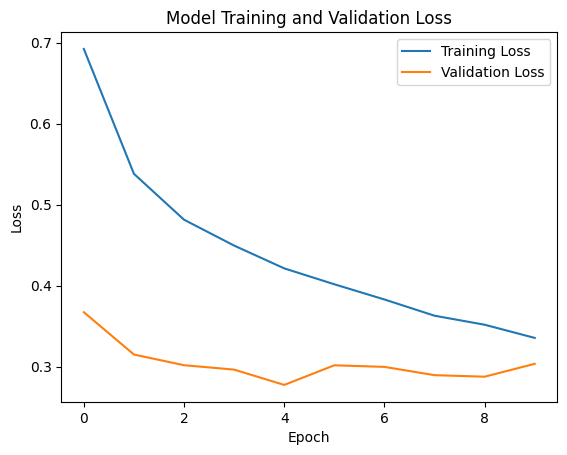

In [81]:
import matplotlib.pyplot as plt

# Plot the training loss
plt.plot(history.history['loss'], label='Training Loss')

# Plot the validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')

# Set the title and labels
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [27]:
model.predict(prepared_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


array([[-0.24619696, -0.32881746, -1.3953488 , -0.68196774]],
      dtype=float32)

In [14]:

# Use the model to predict
# Note: You may need to check the specific model documentation for the correct input and output processing
predictions = model(prepared_image)

TypeError: 'AutoTrackable' object is not callable